## Zero-Shot Learning with Images & CLIP
in this notebook we're gonna apply zero-shot learning on images. For this we're using CLIP, in a sense CLIP has two "brains":
* One for images
* One for sentences

So it can decide "Which sentence fits which image?" Thats why you can compare images with sentences like "A photo taken at down" and see which image fits the description best -> zero-shot classification.

In [1]:
import clip
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from PIL import Image
import os
from tqdm import tqdm
import kagglehub
plt.style.use('seaborn-v0_8')

Below we're gonna load the CLIP-model and preprocesser.

- `model` = the "brain" (image- and textencoder)
- `preprocess` = How you need to cut/ scale the image so the model understands

**ViT-B/32** is a version of the model, its quick a good enough for an example like this but you've got bigger variants that are more accurate but have a heavier workflow.

In [2]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
# of "cuda" als je een NVIDIA GPU hebt

In [3]:
# local model and preprocessor
# see https://openai.com/blog/clip/ for info on different model
model, preprocess = clip.load("ViT-B/32", device=device)  # ViT-L/14@336px is the latest, ViT-B/32 is the first release, use ViT-L/14

100%|███████████████████████████████████████| 338M/338M [01:57<00:00, 3.01MiB/s]


What we're doing below is coming up with "natural language" labels, not classes but sentences. CLIP can compare text- and image meaning, which is the zero-shot learning trick.

The slight difference here is having 4 seperate labels and 1 set text-prompt that you combine so you get 4 differente possible combinations of when the photo was taken.

In [5]:
# zero-shot classification for one image
labels = ['dawn', 'day', 'dusk', 'night']  # the target labels
text_prompts = ['A photo taken at ' + label for label in labels]
print(text_prompts)

['A photo taken at dawn', 'A photo taken at day', 'A photo taken at dusk', 'A photo taken at night']


The data below was taken from a public [Kaggle Page](https://www.kaggle.com/datasets/harrywang/unsplash?resource=download), if you wish to reproduce or run this notebook yourself you must download the dataset from either kagglehub or directly from the page. And either copy my directory or make your own.

(np.float64(-0.5), np.float64(766.5), np.float64(511.5), np.float64(-0.5))

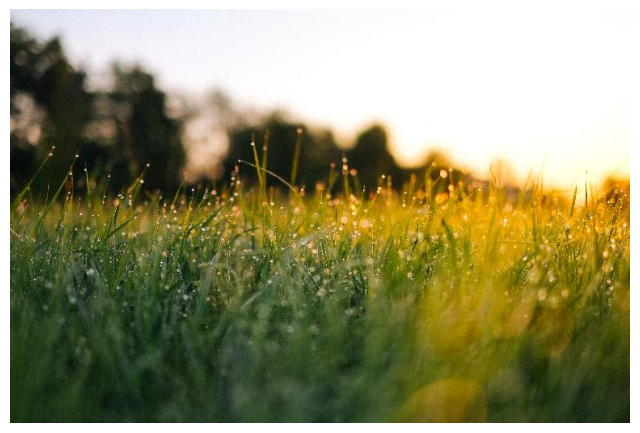

In [7]:
# try different images
#one_img = './1k-compressed/-bDYrrVAZnc.jpg'  # night
#one_img = './1k-compressed/-fjrjyS18BQ.jpg'  # dusk
im = '../data/1k-compressed/-N_UwPdUs7E.jpg'  # dawn
#one_img = './1k-compressed/7kCNXfo35aU.jpg'  # day
plt.imshow(Image.open(im))
plt.axis('off')

## Whats Happening Below?**

**Preparing the input:**
* `preprocess`: Turns the image into a tensor in the format that clip expects (so rezie, crop and normalise)
* `unsqueeze`: adds a batch-dimension, because CLIP always expects a batch (even if it's just one)
* `clip.tokenize()`: Turns our "natural language" labels into tokens that the CLIP "brain" understands.

**Encode and compare**
```python
with torch.no_grad():
    logits_per_image, logits_per_text = model(image, text)
```

Clip has two encoder:

* one for images, so it makes a vector (embedding)
* one for text, so it makes a vector for each sentence

All of these vectors are normalised and the model calculates the cosine similarity between the images and each sentences -> "*how well does this image fit the text?*"

These values are stored in `logits_per_images`

**from raw scores to chances**
```python
probs = logits_per_image.softmax(dim=-1).cpu().numpy()
```
Softmax turns the raw scores into a probability distribution (between 0 and 1). For example the array shown below:

Label probabilities: [[0.4903107  0.18175665 0.3189673  0.00896534]]
This photo is classified as taken at dawn.

[0.49, 0.18, 0.31, 0.008] shows the percentages of the chances. In this case it says that theres a `49% chance` its `dawn`

---

## Summary 
1. You transform your image and label-sentences into a format CLIP understands
2. CLIP turns both of them into vectors
3. CLIP checks: "*Which sentence resonates the most with this image?*" according to the vector values
4. Softmax -> chance, highest chance = your prediction

So: "*This image looks the most like sentence `A photo taken at dawn` -> i predict this is dawn*"

In [8]:
image = preprocess(Image.open(im)).unsqueeze(0).to(device)  # preprocess image
text = clip.tokenize(text_prompts).to(device)  # tokenize the text

# encode the image and text - no used here
#image_features = model.encode_image(image)  # encode image
#text_features = model.encode_text(text)  # encode text

with torch.no_grad():  # inference with no_grad

    # logit scores are cosine similarities between the corresponding image and text features, times 100.
    logits_per_image, logits_per_text = model(image, text)

    #print(logits_per_image, logits_per_text)  # logits are the same

    probs = logits_per_image.softmax(dim=-1).cpu().numpy()  # use softmax to get probabilities

print("Label probabilities:", probs)
choices = np.argmax(probs)  # use argmax to get the largest number as the prediction
print(f'This photo is classified as taken at {labels[choices]}.')

Label probabilities: [[0.49031225 0.18175721 0.3189653  0.00896524]]
This photo is classified as taken at dawn.


In [11]:
# use 1k or 5k dataset - make sure you have `1k-compressed` or `5k-compressed` folders

data_size = '1k'

if data_size == '1k':
    photos = pd.read_csv('../data/photos-1k.csv')
    img_folder = '../data/1k-compressed'
    pred_csv = '../data/photos-1k-pred.csv'
else:
    photos = pd.read_csv('../data/photos-5k.csv')
    img_folder = '../data/5k-compressed'
    pred_csv = '../data/photos-5k-pred.csv'

## Whats happening below?

We define `labels` and `text_prompts` again as we did above to turn into sentences **CLIP** understands. 

* `text` turns into a batch with **4 tokenized** sentences [4, context_length]

Then we process the datset into batches of 500 for performance.

**Build, preprocess and run through CLIP**
````python
for i in tqdm(range(0, total_photos, BATCH_SIZE)):
    ...
````

For every batch **i:i+BATCH_SIZE**:

- Every jpg is loaded en preprocessed (rezie, crop, normalised)
- `np.stack(images)` sticks them onto each other into one array

**Forward pass + chances**
```python
with torch.no_grad():
    ...
```

- `model(image_input, text)` gives every image a score per label (cosine-similarity x scalefactor)
- Softmax -> gives a probability distribution for every image for every label we've made

**Add everything into one and choose predictions**
- `res` takes the complete matrix: each image x chance per label
- `argmax` takes the highest possibility per image
- `np.vectorize` translates the indexes to the labelnames for plotting

---

## Summary

1. We make the labels/ sentences. CLIP responds better to sentences, hence why we add that part to the labels.
2. All sentences are tokenized -> turning them into numbers (vectors) so the model understands
3. Since we're taking all the images in the `1k-folder` we use batches of 500:
    - Each foto is opened
    - And preprocessed (cropped, resized, normalised) so CLIP can work with it
4. Then CLIP compares each image to the labels:
    - "*How well does this image look like label 1,2,3 or 4?*"
    - It then scores each label
5. Softmax turns these scores into "chances", so then we can choose the label with the highest chance as the prediction
6. In the end all results of all batches are stuck together so we've got one big list of predictions and we save this in a .csv-file.

In [ ]:
# zero-shot classification for 1k/5k images
results = []

# zero-shot classification for one image
labels = ['dawn', 'day', 'dusk', 'night']  # the target labels
text_prompts = ['A photo taken at ' + label for label in labels]
print(text_prompts)

text = clip.tokenize(text_prompts).to(device)  # tokenize the text

BATCH_SIZE = 500
total_photos = len(photos)

for i in tqdm(range(0, total_photos, BATCH_SIZE)):

    # preprocess the images by batch
    images = [
        preprocess(
            Image.open(f'./'+ img_folder + f'/{img_id}.jpg')
        ) for img_id in photos['photo_id'][i:i+BATCH_SIZE]
    ]

    # images is now a list of tensors, so we can stack them
    image_input = torch.stack(images).to(device) # type: ignore

    with torch.no_grad():

        # logit scores are cosine similarities between the corresponding image and text features, times 100.
        logits_per_image, logits_per_text = model(image_input, text)

        probs = logits_per_image.softmax(dim=-1).cpu().numpy()  # softmax to get the probs from logits

        results.append(probs)

res = np.concatenate(results, axis=0)  # concat the result
choices = np.argmax(res, axis=1)  # choose the largest prob

get_labels = np.vectorize(lambda x:labels[x])  # vectorized lambda function to get labels
predictions = get_labels(choices)  # an array

#print(len(predictions))  # total 1000 predictions
#print(predictions[:10])  # see the first 10

# save the dataframe to csv
if not os.path.exists(pred_csv):  # skip if images had been processed
    # add the classification results to the dataframe
    photos['taken_time'] = predictions
    photos.to_csv(pred_csv, index=False)

['A photo taken at dawn', 'A photo taken at day', 'A photo taken at dusk', 'A photo taken at night']


100%|██████████| 2/2 [00:32<00:00, 16.27s/it]


C:\Users\MSI\AppData\Local\Temp\ipykernel_91124\214735147.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='taken_time', data=photos_pred, order=sorted_labels, palette='pastel')


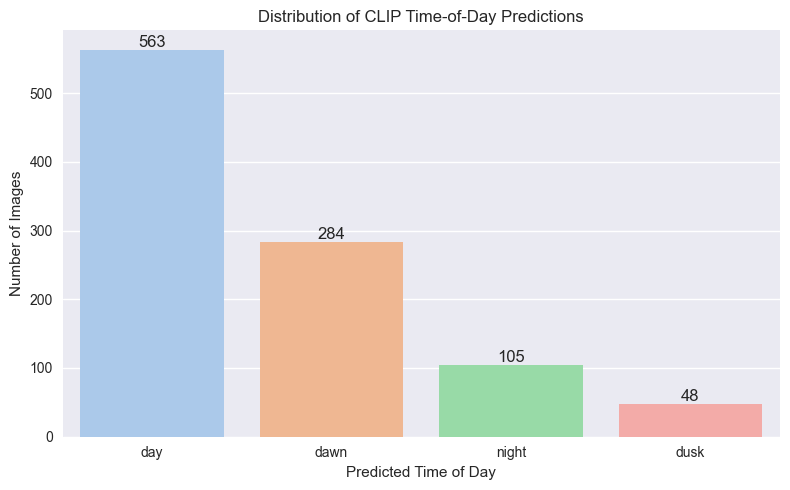

In [ ]:
# random verify the result
# sample one for each cls: dusk, day, dawn, night

photos_pred = pd.read_csv(pred_csv)

import seaborn as sns

# Count the occurrences for each label
counts = photos_pred['taken_time'].value_counts()
# Sort labels by count descending
sorted_labels = counts.sort_values(ascending=False).index.tolist()

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='taken_time', data=photos_pred, order=sorted_labels, palette='pastel')
plt.title('Distribution of CLIP Time-of-Day Predictions')
plt.xlabel('Predicted Time of Day')
plt.ylabel('Number of Images')

# Add counts on top of bars
for p in ax.patches:
    count = int(p.get_height()) # type: ignore
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2, p.get_height()), # type: ignore
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

The histogram above shows the distribution of predictions the model gave.

- 563 as day
- 284 as dawn
- 105 as night
- 48 as dusk

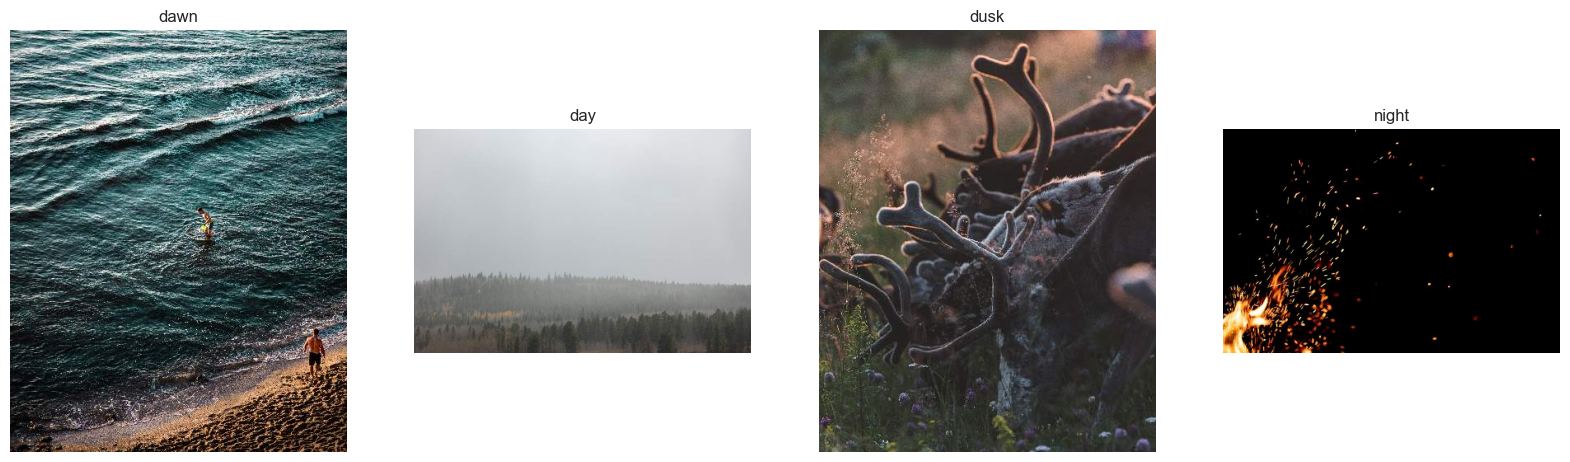

In [22]:
# random verify the result
# sample one for each cls: dusk, day, dawn, night

photos_pred = pd.read_csv(pred_csv)
samples = photos_pred.groupby('taken_time').sample(1)

ids = list(samples.photo_id)
labels = list(samples.taken_time)
total_photos = len(ids)
sample_photos = [f'./' + img_folder + '/' + idx + '.jpg' for idx in ids]

# display the result horizontally
fig = figure(figsize=(20, 80))

for i in range(total_photos):
    ax = fig.add_subplot(1, total_photos, i+1)
    image = imread(sample_photos[i])
    imshow(image)
    ax.set_title(labels[i])
    axis('off')

## What happening below?

#### Label & Prompts
`labels, text_prompts & text`

**text** is a tensor with 2 new prompts/ labels (`a photo taken indoor` or `a photo taken outdoor`)

#### Batch-loop
```python
for i in tqdm(range(0, total_photos, BATCH_SIZE)):
    ...
```
We load 500 images and preprocess them (resize, crop and normalise)

**np.stack** then sticks them into one array and then onto torch.sensor

#### CLIP forward pass
```python
with torch.no_grad():
    ...
```
CLIP makes an embedding and calculates the cosine-similarty x scale factor between each image and each prompt.
(it basically makes a prediction how confident its in the image being indoor or outdoor)

**softmax** then looks which prediction-score is higher and takes that as the final prediction (indoor or outdoor)

#### Add together & choose
`res, choices & predictions`

**res** contains all chances for all images
**argmax** takes the highest chance for both labels

---

## Summary
1. We come up with two "natural-language" labels:
    - "A photo taken indoor"
    - "A photo taken outdoor"
2. We put all the images in batches again, 500 at a time. Each image is then processed for CLIP
3. CLIP then decides per image the chance its either taken indoor or outdoor, the highest chance is the prediction
4. This gives us a prediction for each image wether its most likely "indoor" or "outdoor" and put this in a .csv-file

In [23]:
# another example: zero-shot classification for 1k/5k images

results = []

# zero-shot classification for one image
labels = ['indoor', 'outdoor']  # the target labels
text_prompts = ['A photo taken ' + label for label in labels]
print(text_prompts)

text = clip.tokenize(text_prompts).to(device)  # tokenize the text

BATCH_SIZE = 500
total_photos = len(photos)

for i in tqdm(range(0, total_photos, BATCH_SIZE)):

    # preprocess the images by batch
    images = [
        preprocess(
            Image.open(f'./' + img_folder+ f'/{img_id}.jpg')
        ) for img_id in photos['photo_id'][i:i+BATCH_SIZE]
    ]

    image_input = torch.tensor(np.stack(images)).to(device)

    with torch.no_grad():

        # logit scores are cosine similarities between the corresponding image and text features, times 100.
        logits_per_image, logits_per_text = model(image_input, text)

        probs = logits_per_image.softmax(dim=-1).cpu().numpy()  # softmax to get the probs from logits

        results.append(probs)

res = np.concatenate(results, axis=0)  # concat the result
choices = np.argmax(res, axis=1)  # choose the largest prob

get_labels = np.vectorize(lambda x:labels[x])  # vectorized lambda function to get labels
predictions = get_labels(choices)  # an array

#print(len(predictions))  # total 1000 predictions
#print(predictions[:10])  # see the first 10

if not os.path.exists(pred_csv):  # skip if images had been processed
    # add the classification results to the dataframe
    photos['taken_space'] = predictions
    photos.to_csv(pred_csv, index=False)

['A photo taken indoor', 'A photo taken outdoor']


100%|██████████| 2/2 [00:26<00:00, 13.07s/it]


C:\Users\MSI\AppData\Local\Temp\ipykernel_91124\4040191467.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='taken_space', data=photos_pred, order=sorted_labels, palette='pastel')


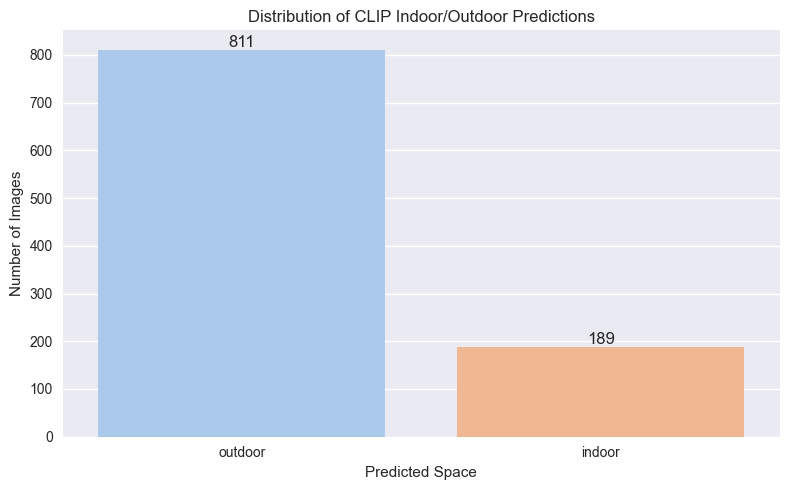

In [25]:
# random verify the indoor/outdoor classification

photos_pred = pd.read_csv(pred_csv)

# Count the occurrences for each label
counts = photos_pred['taken_space'].value_counts()
# Sort labels by count descending
sorted_labels = counts.sort_values(ascending=False).index.tolist()

plt.figure(figsize=(8, 5))
ax = sns.countplot(x='taken_space', data=photos_pred, order=sorted_labels, palette='pastel')
plt.title('Distribution of CLIP Indoor/Outdoor Predictions')
plt.xlabel('Predicted Space')
plt.ylabel('Number of Images')

# Add counts on top of bars
for p in ax.patches:
    count = int(p.get_height())  # type: ignore
    ax.annotate(f'{count}', (p.get_x() + p.get_width() / 2, p.get_height()),  # type: ignore
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

This shows us CLIP thinks 811 images were taken outdoor and 189 were taken indoor

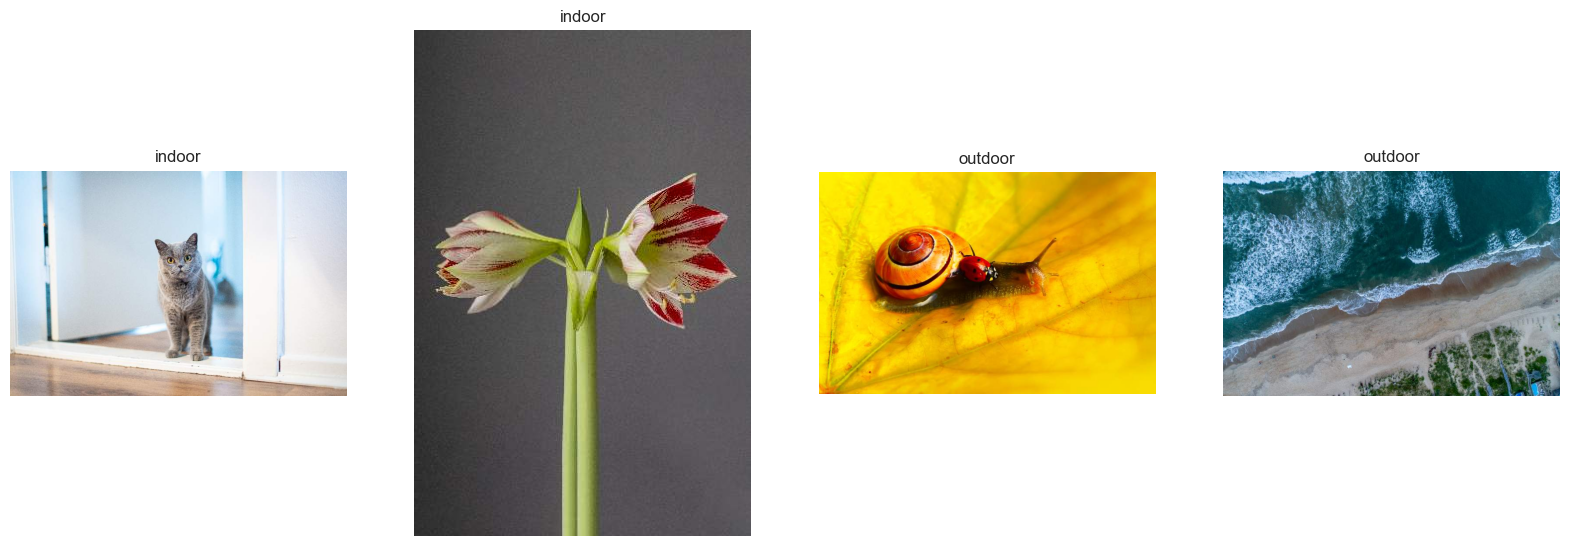

In [ ]:
# random verify the result
# sample two for each cls: dusk, day, dawn, night

photos_pred = pd.read_csv(pred_csv)
samples = photos_pred.groupby('taken_space').sample(2)

ids = list(samples.photo_id)
labels = list(samples.taken_space)
total_photos = len(ids)
sample_photos = [f'./' + img_folder+ '/'+ idx + '.jpg' for idx in ids]

# display the result horizontally
fig = figure(figsize=(20, 80))

for i in range(total_photos):
    ax = fig.add_subplot(1, total_photos, i+1)
    image = imread(sample_photos[i])
    imshow(image)
    ax.set_title(labels[i])
    axis('off')

C:\Users\MSI\AppData\Local\Temp\ipykernel_91124\906906404.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='taken_time', data=photos_pred, order=sorted_time,
C:\Users\MSI\AppData\Local\Temp\ipykernel_91124\906906404.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='taken_space', data=photos_pred, order=sorted_space,


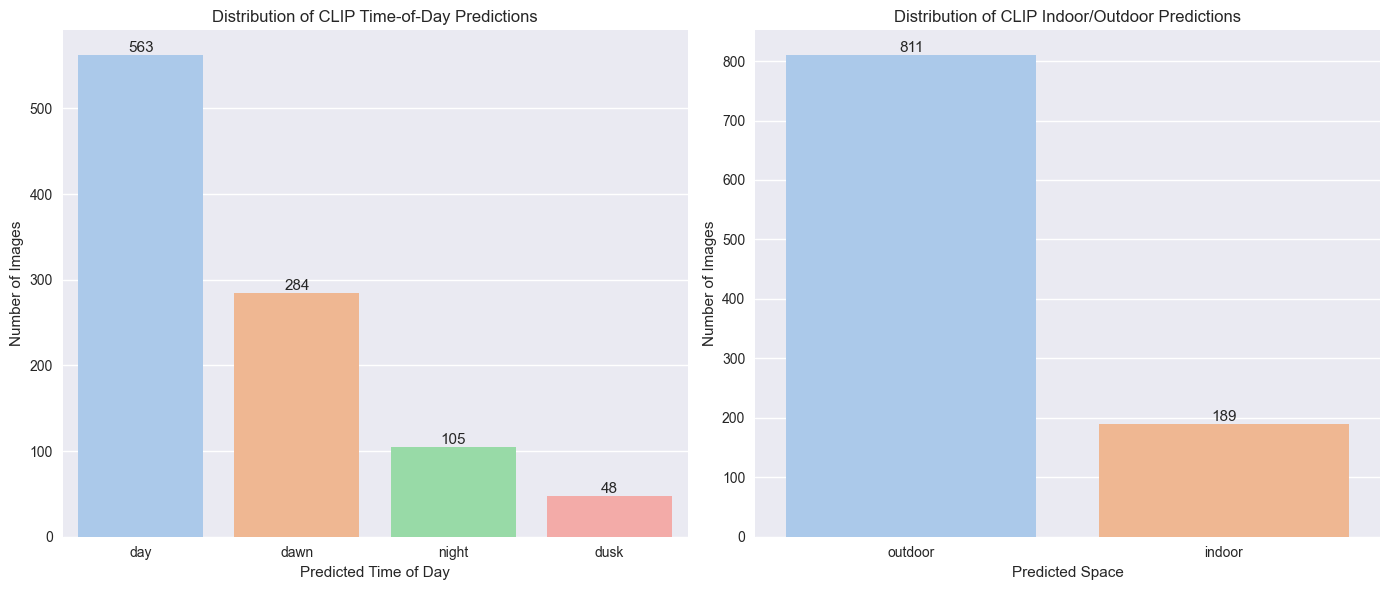

In [27]:
photos_pred = pd.read_csv(pred_csv)

fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# ---- taken_time ----
counts_time = photos_pred['taken_time'].value_counts()
sorted_time = counts_time.sort_values(ascending=False).index.tolist()

sns.countplot(x='taken_time', data=photos_pred, order=sorted_time,
              palette='pastel', ax=ax[0])
ax[0].set_title('Distribution of CLIP Time-of-Day Predictions')
ax[0].set_xlabel('Predicted Time of Day')
ax[0].set_ylabel('Number of Images')

for p in ax[0].patches:
    count = int(p.get_height())
    ax[0].annotate(f'{count}', (p.get_x() + p.get_width() / 2, p.get_height()),
                   ha='center', va='bottom', fontsize=11)

# ---- taken_space ----
counts_space = photos_pred['taken_space'].value_counts()
sorted_space = counts_space.sort_values(ascending=False).index.tolist()

sns.countplot(x='taken_space', data=photos_pred, order=sorted_space,
              palette='pastel', ax=ax[1])
ax[1].set_title('Distribution of CLIP Indoor/Outdoor Predictions')
ax[1].set_xlabel('Predicted Space')
ax[1].set_ylabel('Number of Images')

for p in ax[1].patches:
    count = int(p.get_height())
    ax[1].annotate(f'{count}', (p.get_x() + p.get_width() / 2, p.get_height()),
                   ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.show()

## Conclusion
This notebook showed how zero-shot learning works with **CLIP**: a model that can place images and texts in the same meaning space. Without any extra training or labelling, it could classify the images based on a made up label like "dawn, dusk, indoor, outdoor" etc.

The results show that CLIP is capable the sperate meaningful categories. 

**Summary of the technology**
The model we used, CLIP, has two encoders: one for images and one for text. It turns an image into a vector (embedding) and does the same for text, like: "*A photo taken at night*". Now that both the image and text are in the same format, CLIP can calculate _how well an image and text match each other_ using cosine similarity.

The notebook showed this in the following way:

1. We made "natural-language" labels (prompts) for our categories, ex. dawn, day, dusk, night or indoor/outdoor
2. For each image CLIP compared: "*Which sentence matched the image the most?*"
3. The sentence with the highest score was chosen as the prediction

So the model only used its general knowledge of images and texts to make this prediction, no extra training was used: zero-shot learning.